In [1]:
from confirm.outlaw.nb_util import setup_nb

setup_nb()
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from confirm.mini_imprint import batch, grid, adagrid, driver, db

In [2]:
@jax.jit
def _sim(samples, theta, null_truth):
    return jnp.where(
        null_truth[:, None, 0],
        # negate so that we can do a less than comparison
        -(theta[:, None, 0] + samples[None, :]),
        jnp.inf,
    )


class ZTest1D:
    def __init__(self, seed, max_K, sim_batch_size=2048):
        self.family = "normal"
        self.sim_batch_size = sim_batch_size
        self.dtype = jnp.float32

        # sample normals and then compute the CDF to transform into the
        # interval [0, 1]
        key = jax.random.PRNGKey(seed)
        self.samples = jax.random.normal(key, shape=(max_K,), dtype=self.dtype)
        self._sim_batch = batch.batch(
            _sim, self.sim_batch_size, in_axes=(0, None, None), out_axes=(1,)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        return self._sim_batch(self.samples[begin_sim:end_sim], theta, null_truth)

## Calculate Type I Error

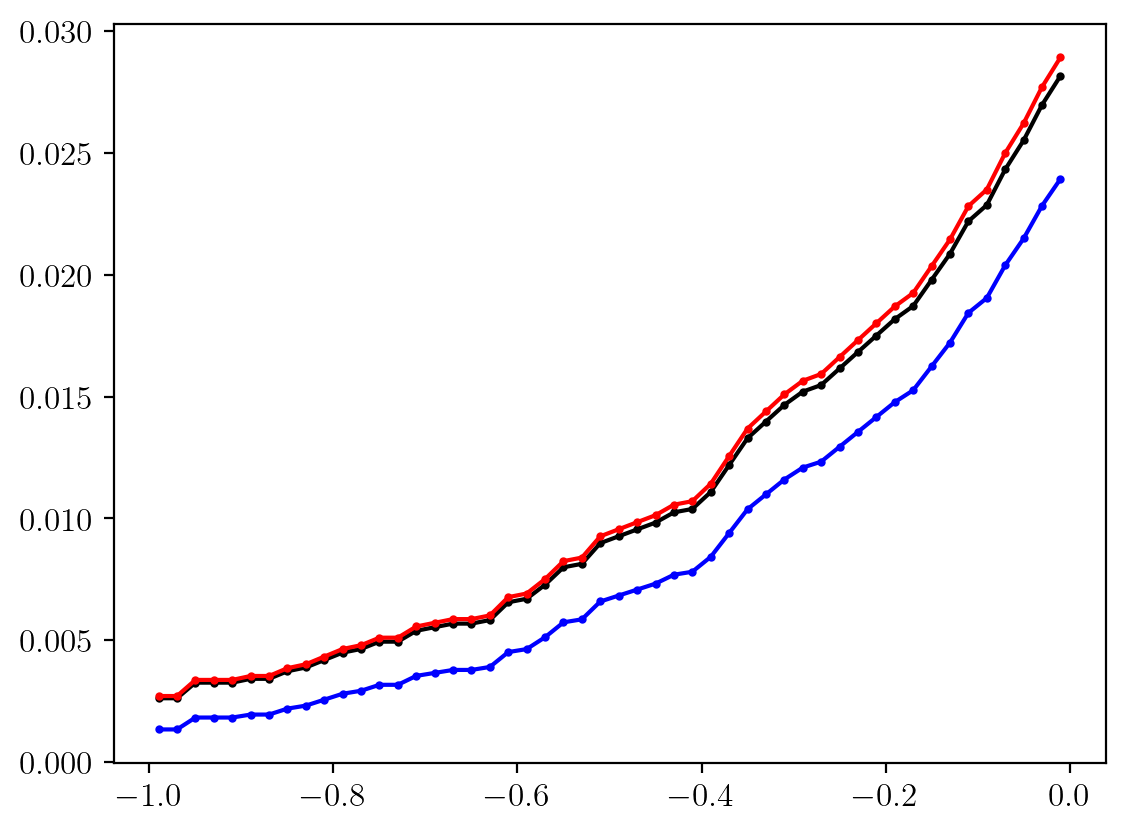

In [4]:
K = 8192
model = ZTest1D(seed=0, max_K=K)

N = 100
theta, radii = grid.cartesian_gridpts([-1], [1], [N])
Hs = [grid.HyperPlane(np.array([-1]), 0)]
g = grid.init_grid(theta, radii, K).add_null_hypos(Hs).prune()

# TODO: is there any problem from using the same seed with the bootstrap
# indices and the simulations?
dd = driver.Driver(model)

# lam = -1.96 because we negated the statistics so we can do a less thanj
# comparison.
rej_df = dd.rej(g.df, -1.96)

plt.plot(g.df["theta0"], rej_df["TI_sum"] / rej_df["K"], "b-o", markersize=2)
plt.plot(g.df["theta0"], rej_df["TI_cp_bound"], "k-o", markersize=2)
plt.plot(g.df["theta0"], rej_df["TI_bound"], "r-o", markersize=2)
plt.show()

## Adagrid Tuning

In [38]:
init_K = 2048
n_K_double = 4
model = ZTest1D(seed=1, max_K=init_K * 2**n_K_double)


N = 1
theta, radii = grid.cartesian_gridpts([-1], [1], [N])
Hs = [grid.HyperPlane(np.array([-1]), 0)]
g = grid.init_grid(theta, radii, K).add_null_hypos(Hs).prune()

ada, reports = adagrid.adagrid(model, g, nB=5)

{
    'i': 1,
    'bias': '0.00005',
    'std_tie': '0.00031',
    'spread_tie': '0.0010',
    'grid_cost': '0.0193',
    'n_refine': 1,
    'n_deepen': 0,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 2,
    'bias': '0.00002',
    'std_tie': '0.00076',
    'spread_tie': '0.0024',
    'grid_cost': '0.0127',
    'n_refine': 1,
    'n_deepen': 1,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 3,
    'bias': '-0.00012',
    'std_tie': '0.00142',
    'spread_tie': '0.0046',
    'grid_cost': '0.0073',
    'n_refine': 1,
    'n_deepen': 2,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 4,
    'bias': '-0.00010',
    'std_tie': '0.00164',
    'spread_tie': '0.0054',
    'grid_cost': '0.0039',
    'n_refine': 1,
    'n_deepen': 3,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 5,
    'bias': '0.00015',
    'std_tie': '0.00161',
    'spread_tie': '0.0055',
    'grid_cost': '0.0020',
    'n_refine': 1,
    'n_deepen': 4,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 6,
    'bias': '0.00032',
    'std_tie': '0.00166',
    'spread_tie': '0.0056',
    'grid_cost': '0.0010',
    'n_refine': 2,
    'n_deepen': 4,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 7,
    'bias': '0.00061',
    'std_tie': '0.00139',
    'spread_tie': '0.0044',
    'grid_cost': '0.0005',
    'n_refine': 3,
    'n_deepen': 5,
    'n_finished': 0,
    'n_impossible': 0
}

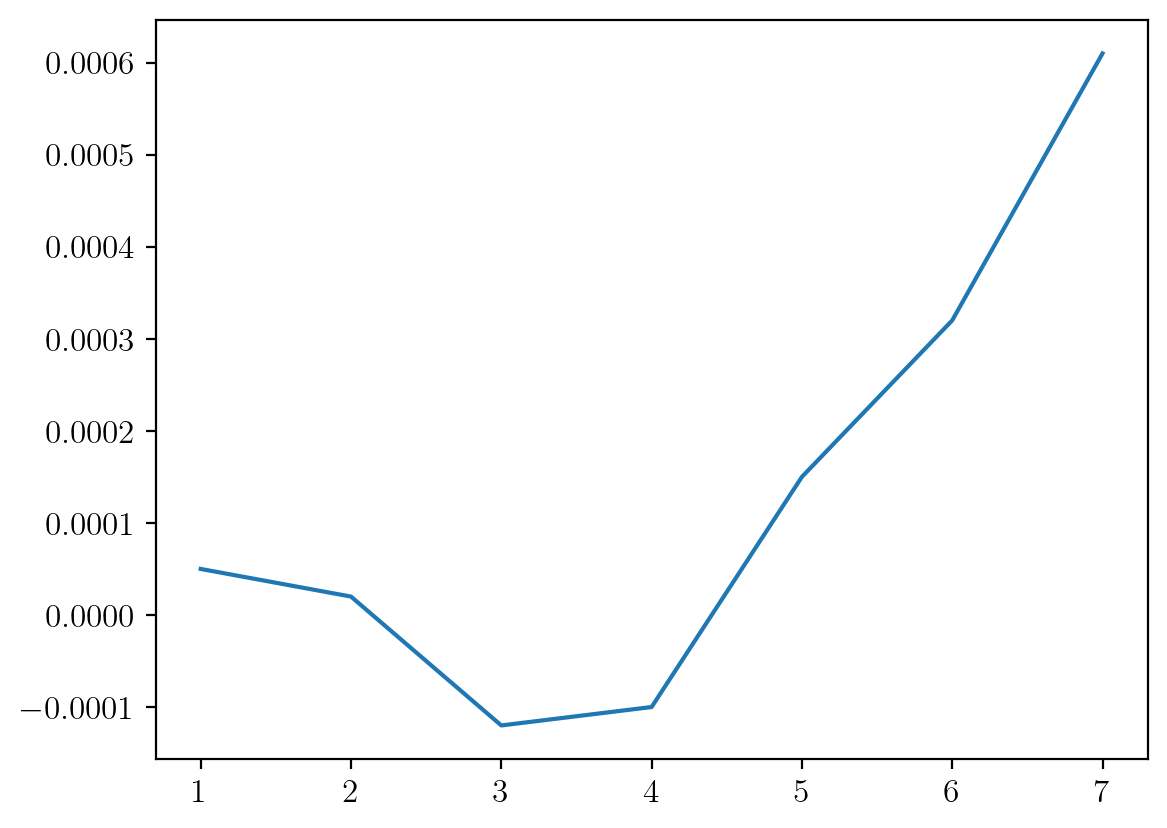

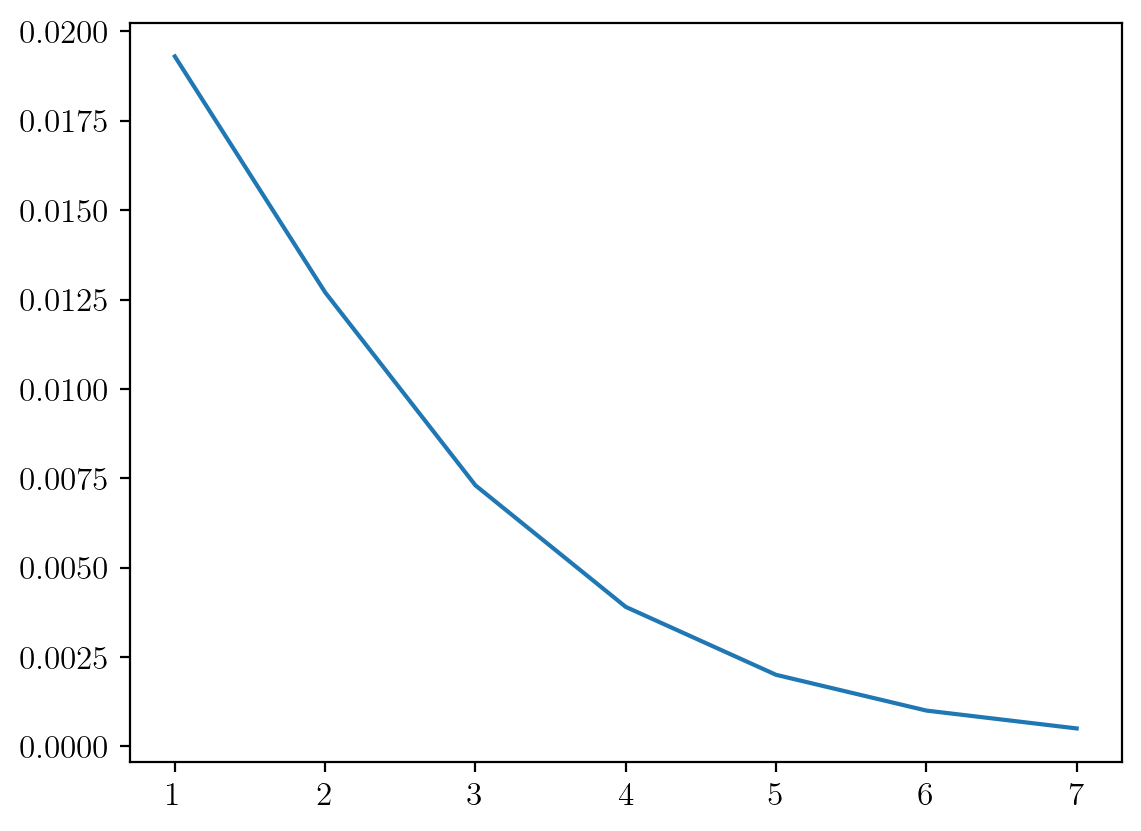

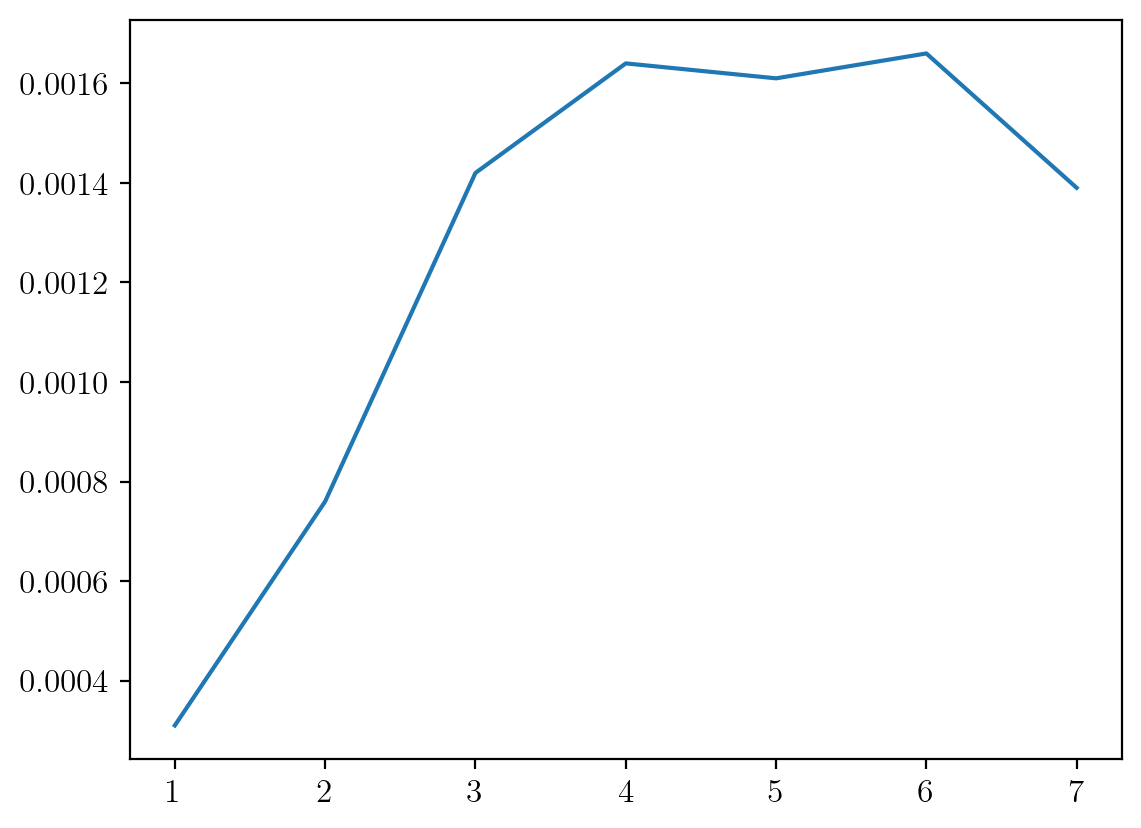

In [39]:
evolution = pd.DataFrame(reports)
plt.plot(evolution["i"], evolution["bias"].astype(float))
plt.show()
plt.plot(evolution["i"], evolution["grid_cost"].astype(float))
plt.show()
plt.plot(evolution["i"], evolution["std_tie"].astype(float))
plt.show()

In [40]:
all = ada.tiledb.get_all()
all = all.loc[all["active"]]
all.nsmallest(10, "orderer")

,K,theta0,radii0,parent_id,birthday,active,locked,eligible,id,null_truth0,alpha0,grid_cost,impossible,orderer,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_min_lams,twb_mean_lams,twb_max_lams
36,16384,-0.007812,0.007812,10221471206075269121,7,True,False,True,10221471223255138304,True,0.024474,0.000526,False,-1.959613,-1.952203,-1.954837,-1.952289,-1.949400,-1.913747,-1.965506,-1.935234,-1.959613,-1.949958,-1.949400,-1.930338,-1.959613,-1.944909,-1.930338
38,32768,-0.046875,0.015625,10221471188895399936,7,True,False,True,10221471223255138306,True,0.023958,0.001042,False,-1.945770,-1.933928,-1.936861,-1.948508,-1.926444,-1.951140,-1.932884,-1.906965,-1.945770,-1.925329,-1.932884,-1.913226,-1.945770,-1.924835,-1.906965
37,16384,-0.023438,0.007812,10221471206075269120,7,True,False,True,10221471223255138305,True,0.024474,0.000526,False,-1.943988,-1.936578,-1.939212,-1.936664,-1.933775,-1.898122,-1.949881,-1.919609,-1.943988,-1.934333,-1.933775,-1.914713,-1.943988,-1.929284,-1.914713
39,65536,-0.093750,0.031250,10221471188895399937,7,True,False,True,10221471223255138307,True,0.022954,0.002046,False,-1.932866,-1.907218,-1.887053,-1.938032,-1.904322,-1.925151,-1.932601,-1.910165,-1.886240,-1.886869,-1.920376,-1.932866,-1.932866,-1.907303,-1.886240
40,131072,-0.187500,0.062500,10221471188895399938,7,True,False,True,10221471223255138308,True,0.021055,0.003945,False,-1.848806,-1.847985,-1.831626,-1.860637,-1.827322,-1.842759,-1.868471,-1.822834,-1.843320,-1.837649,-1.848806,-1.848364,-1.848806,-1.840195,-1.822834
31,131072,-0.312500,0.062500,10221471188895399939,7,True,False,True,10221471240435007489,True,0.021055,0.003945,False,-1.723806,-1.722985,-1.706626,-1.735637,-1.702322,-1.717759,-1.743471,-1.697834,-1.718320,-1.712649,-1.723806,-1.723364,-1.723806,-1.715195,-1.697834
30,131072,-0.437500,0.062500,10221471188895399939,7,True,False,True,10221471240435007488,True,0.021055,0.003945,False,-1.598806,-1.597985,-1.581626,-1.610637,-1.577322,-1.592759,-1.618471,-1.572834,-1.593320,-1.587649,-1.598806,-1.598364,-1.598806,-1.590195,-1.572834
33,131072,-0.562500,0.062500,10221471206075269123,7,True,False,True,10221471240435007491,True,0.021055,0.003945,False,-1.473806,-1.472985,-1.456626,-1.485637,-1.452322,-1.467759,-1.493471,-1.447834,-1.468320,-1.462649,-1.473806,-1.473364,-1.473806,-1.465195,-1.447834
32,131072,-0.687500,0.062500,10221471206075269123,7,True,False,True,10221471240435007490,True,0.021055,0.003945,False,-1.348806,-1.347985,-1.331626,-1.360637,-1.327322,-1.342759,-1.368471,-1.322834,-1.343320,-1.337649,-1.348806,-1.348364,-1.348806,-1.340195,-1.322834
35,131072,-0.812500,0.062500,10221471206075269122,7,True,False,True,10221471240435007493,True,0.021055,0.003945,False,-1.223806,-1.222985,-1.206626,-1.235637,-1.202322,-1.217759,-1.243471,-1.197834,-1.218320,-1.212649,-1.223806,-1.223364,-1.223806,-1.215195,-1.197834


In [41]:
import scipy.stats

lamss = all["lams"].min()
true_err = 1 - scipy.stats.norm.cdf(-lamss)
lamss, true_err

(-1.952203392982483, 0.02545703076235839)

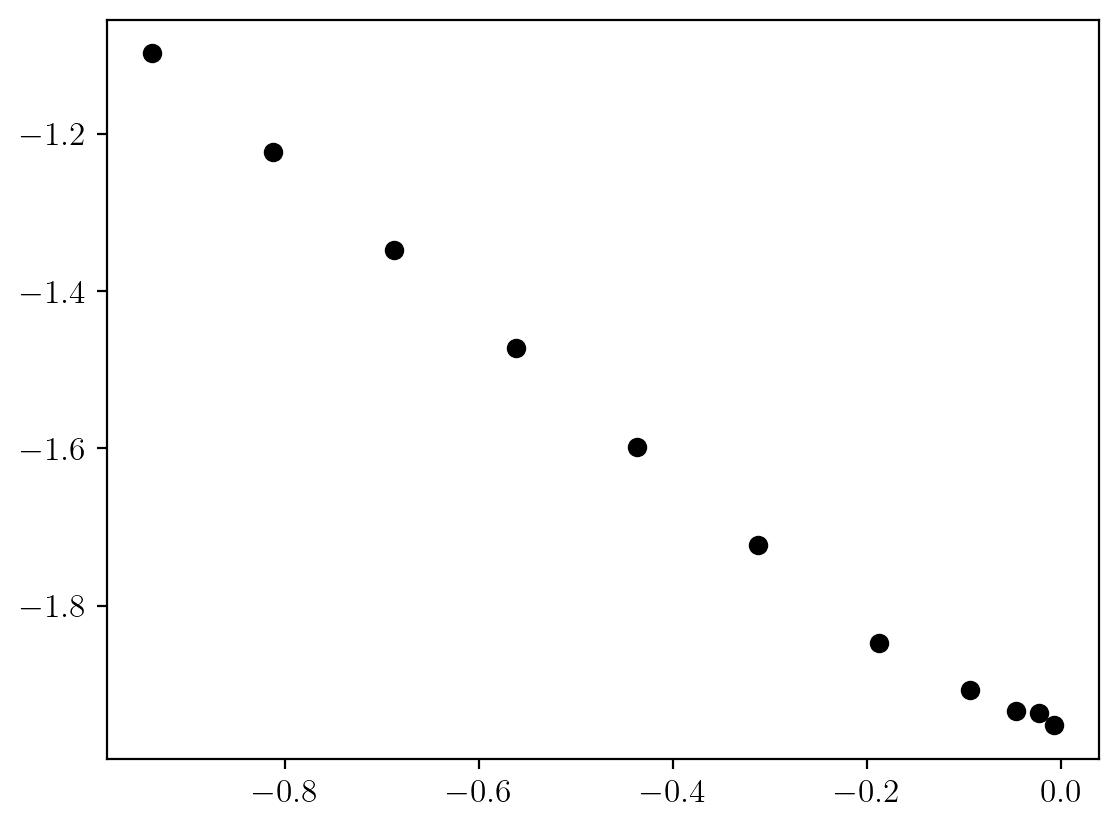

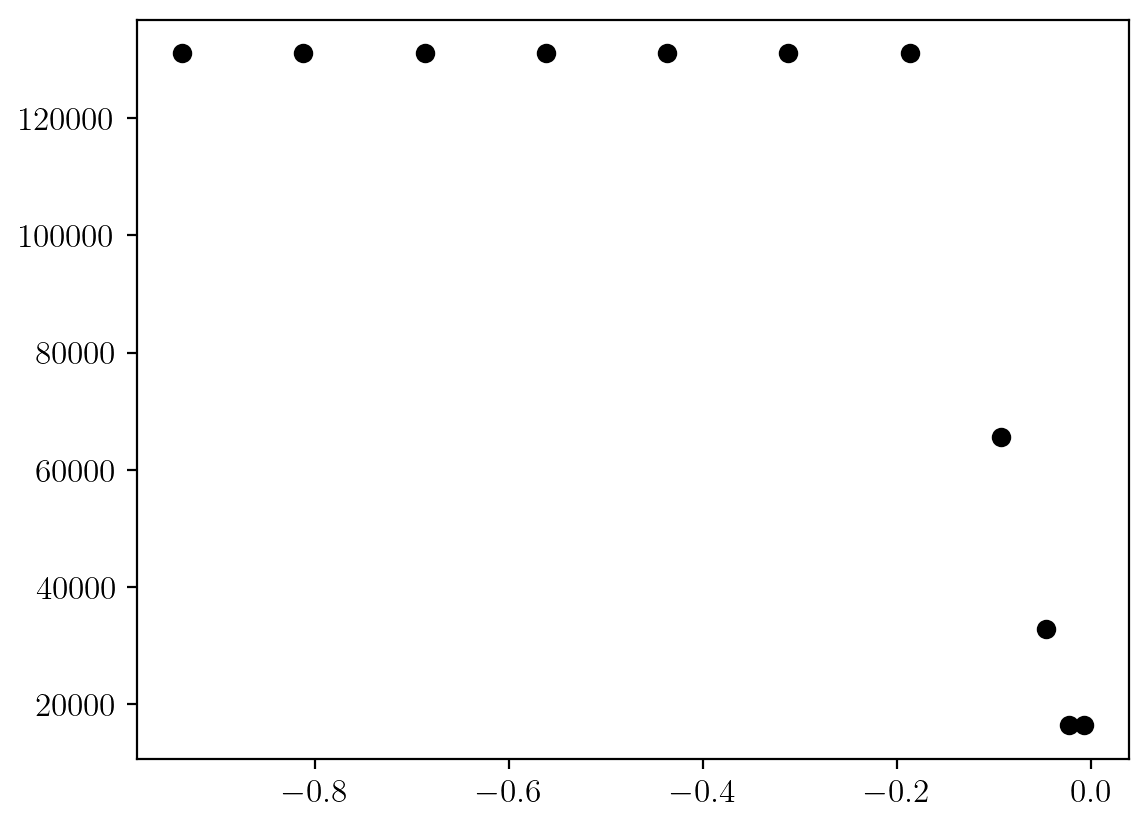

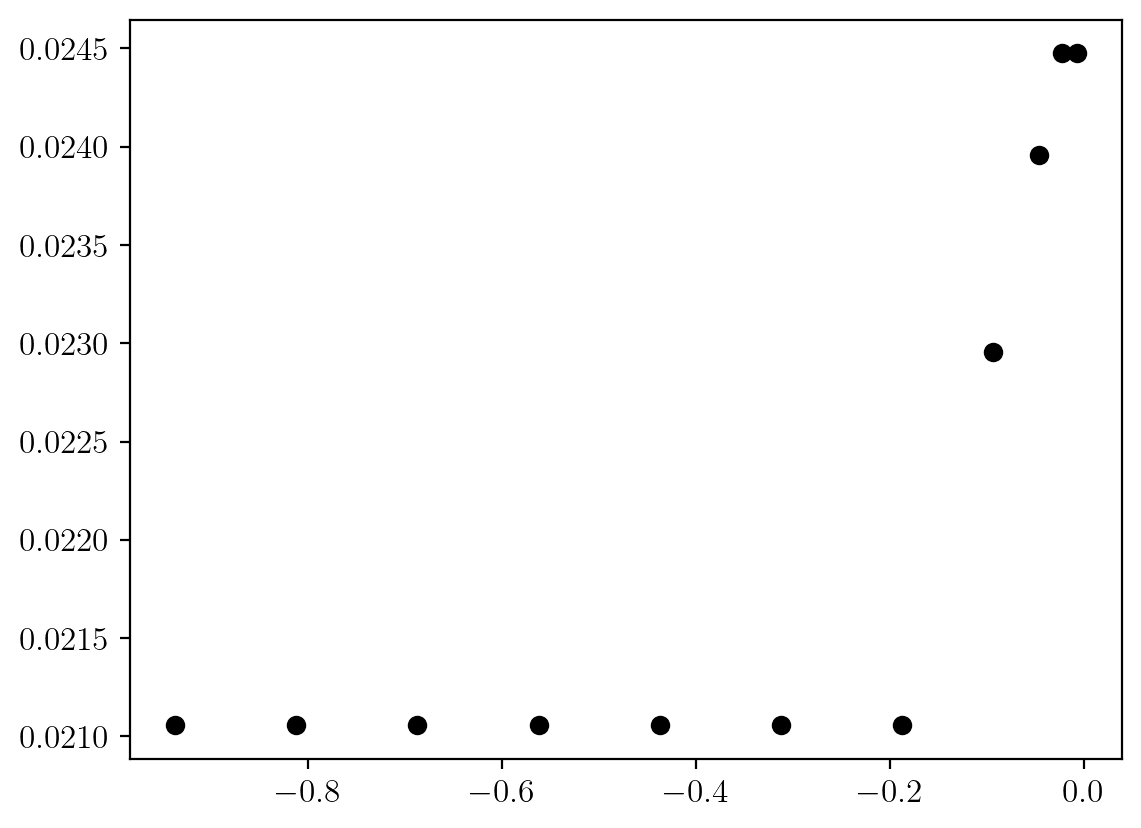

In [42]:
plt.plot(all["theta0"], all["lams"], "ko")
plt.show()
plt.plot(all["theta0"], all["K"], "ko")
plt.show()
plt.plot(all["theta0"], all["alpha0"], "ko")
plt.show()